In [471]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcNumRings
from copy import deepcopy

def calculate_chemical_properties(dictionary_list):
    updated_list = deepcopy(dictionary_list)  # Create a deep copy of the original list
    for entry in updated_list:
        reactant_smiles = entry['reactants']
        product_smiles = entry['products']

        # Initialize RDKit molecule objects from SMILES
        reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        product_mol = Chem.MolFromSmiles(product_smiles)

        if reactant_mol is not None and product_mol is not None:
            # Calculate carbon difference
            num_carbon_reactants = sum([atom.GetAtomicNum() == 6 for atom in reactant_mol.GetAtoms()])
            num_carbon_products = sum([atom.GetAtomicNum() == 6 for atom in product_mol.GetAtoms()])
            entry['carbon_difference'] = abs(num_carbon_reactants - num_carbon_products)
            
            # Calculate total number of carbons
            entry['total_carbons'] = num_carbon_reactants + num_carbon_products

            # Calculate total number of bonds
            entry['total_bonds'] = abs(reactant_mol.GetNumBonds() - product_mol.GetNumBonds())

            # Calculate total number of rings
            entry['total_rings'] = abs(CalcNumRings(reactant_mol) - CalcNumRings(product_mol))
        else:
            entry['carbon_difference'] = "Invalid SMILES"
            entry['total_carbons'] = "Invalid SMILES"
            entry['total_bonds'] = "Invalid SMILES"
            entry['total_rings'] = "Invalid SMILES"

        # Process for fragment count calculation
        # reactant_fragment_count = len(Chem.GetMolFrags(reactant_mol, asSmiles=True))
        # product_fragment_count = len(Chem.GetMolFrags(product_mol, asSmiles=True))
        # entry['fragment_count'] = reactant_fragment_count + product_fragment_count


        # Process for fragment count calculation
        reactant_fragment_count = len(reactant_smiles.split('.'))
        product_fragment_count = len(product_smiles.split('.'))
        total_fragment_count = reactant_fragment_count + product_fragment_count
        entry['fragment_count'] = total_fragment_count

    return updated_list


In [472]:
import sys
sys.path.append('../../../')
from SynRBL.rsmi_utils import load_database
import re
from rdkit import Chem


def remove_atom_mapping_from_reaction_smiles(reaction_smiles):
    """
    Remove atom mapping from a reaction SMILES string.
    
    Parameters:
    - reaction_smiles (str): A reaction SMILES string with atom mapping.
    
    Returns:
    - str: A reaction SMILES string without atom mapping.
    """
    # Split the reaction SMILES into its components (reactants, agents, products)
    parts = reaction_smiles.split('>>')
    
    # Remove atom mapping from each part
    cleaned_parts = [Chem.CanonSmiles(re.sub(r":\d+", "", part)) for part in parts]
    
    # Concatenate the cleaned parts back into a reaction SMILES string
    cleaned_reaction_smiles = '>>'.join(cleaned_parts)
    
    return cleaned_reaction_smiles



# Merge mol MCS

In [555]:
import pandas as pd
from SynRBL.rsmi_utils import load_database
from IPython.display import clear_output

data_name = 'golden_dataset'
data = pd.read_csv(f'../../../Pipeline/Validation/Analysis/SynRBL - {data_name}.csv').drop(['Note'], axis=1)
data.loc[data['Result'] == 'CONSIDER', 'Result']=False

merge_data = load_database(f'../../../Data/Validation_set/{data_name}/MCS/MCS_Impute.json.gz')
mcs_data = load_database(f'../../../Data/Validation_set/{data_name}/mcs_based_reactions.json.gz')
mcs_data = calculate_chemical_properties(mcs_data)
clear_output(wait=False)
mcs_data[0]

{'reactions': '[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=[CH2:8].[NH2:11][CH:10]([CH3:9])[CH:12]([OH:13])[CH:14]=[CH2:15]>>[CH:14](=[CH:7][CH2:6][S:5][CH2:4][C:2]([CH3:1])=[O:3])[CH:12]([OH:13])[CH:10]([NH2:11])[CH3:9]',
 'id': 'golden_1',
 'reactants': '[CH3:1][C:2](=[O:3])[CH2:4][S:5][CH2:6][CH:7]=[CH2:8].[NH2:11][CH:10]([CH3:9])[CH:12]([OH:13])[CH:14]=[CH2:15]',
 'products': '[CH:14](=[CH:7][CH2:6][S:5][CH2:4][C:2]([CH3:1])=[O:3])[CH:12]([OH:13])[CH:10]([NH2:11])[CH3:9]',
 'R-id': 'golden_dataset_1',
 'carbon_balance_check': 'products',
 'carbon_difference': 2,
 'total_carbons': 20,
 'total_bonds': 1,
 'total_rings': 0,
 'fragment_count': 3}

In [561]:
id = [value['R-id'] for value in merge_data]
new_mcs = [value for value in mcs_data if value['R-id'] in id]

In [562]:
len(new_mcs)

887

In [564]:
new_mcs[-1]['R-id']

'golden_dataset_1478'

In [563]:
merge_data[-1]['R-id']

'golden_dataset_1478'

In [538]:
data['Result'].value_counts()

Result
TRUE        595
FALSE       276
CONSIDER     16
Name: count, dtype: int64

In [473]:
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcNumRings

def count_boundary_atoms_products_and_calculate_changes(list_of_dicts):
    for item in list_of_dicts:
        count = 0  # Initialize count for boundary_atoms_products
        # Initialize variables for bond and ring changes
        bond_change = 0
        ring_change = 0
        
        if 'boundary_atoms_products' in item and item['boundary_atoms_products']:
            for i in item['boundary_atoms_products']:
                if isinstance(i, dict):
                    count += 1
                elif isinstance(i, list):
                    for j in i:
                        if isinstance(j, dict):
                            count += 1
        
        # Split new_reactions into reactant and product SMILES and calculate changes
        
        reactant_product = item['new_reaction'].split('>>')
        if len(reactant_product) == 2:  # Ensure there are both reactant and product
            reactant_smiles, product_smiles = reactant_product
            reactant_mol = Chem.MolFromSmiles(reactant_smiles)
            product_mol = Chem.MolFromSmiles(product_smiles)
            
            if reactant_mol and product_mol:
                # Calculate bond change
                bond_change = abs(reactant_mol.GetNumBonds() - product_mol.GetNumBonds())
                # Calculate ring change
                ring_change = abs(CalcNumRings(reactant_mol) - CalcNumRings(product_mol))
        
        # Add calculated values to the dictionary
        item['num_boundary'] = count
        item['bond_change_merge'] = bond_change
        item['ring_change_merge'] = ring_change

    return list_of_dicts

In [600]:
import pandas as pd

def process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=True):
    """
    Processes and combines datasets from specified paths.

    Parameters:
    - list_data (list): List of dataset names.
    - pipeline_path (str): Path to the pipeline files.
    - data_path (str): Path to the data files.

    Returns:
    - pd.DataFrame: Combined DataFrame of all processed datasets.
    """
    data_all = pd.DataFrame()
    
    for data_name in list_data:
        # Load dataset CSV and adjust columns
        data_csv_path = f'{pipeline_path}/Validation/Analysis/SynRBL - {data_name}.csv'
        data = pd.read_csv(data_csv_path).drop(['Note'], axis=1)
        print(data.shape)
        data.loc[data['Result'] == 'CONSIDER', 'Result'] = False
        data.loc[data['Result'] == 'FALSE', 'Result'] = False
        data.loc[data['Result'] == 'TRUE', 'Result'] = True
        #data['Result'] =

        # Load and process additional data
        merge_data_path = f'{data_path}/Validation_set/{data_name}/MCS/MCS_Impute.json.gz'
        mcs_data_path = f'{data_path}/Validation_set/{data_name}/mcs_based_reactions.json.gz'
        
        merge_data = load_database(merge_data_path)
        print(len(merge_data))
        merge_data = count_boundary_atoms_products_and_calculate_changes(merge_data)
        mcs_data = load_database(mcs_data_path)
        id = [value['R-id'] for value in merge_data]
        mcs_data = [value for value in mcs_data if value['R-id'] in id]
        mcs_data = calculate_chemical_properties(mcs_data)
        print(len(mcs_data))
        #clear_output(wait=False)
        
        # Combine data
        combined_data = pd.concat([
            pd.DataFrame(mcs_data)[['R-id', 'reactions', 'carbon_difference', 'fragment_count', 'total_carbons', 'total_bonds', 'total_rings']],
            data,
            pd.DataFrame(merge_data)[['mcs_carbon_balanced', 'num_boundary', 'ring_change_merge', 'bond_change_merge']],
        ], axis=1)
        print(combined_data.isnull().sum().sum())
        combined_data.loc[(combined_data['mcs_carbon_balanced'] == False) & (combined_data['Result'] == True), 'Result']=False
        if remove_undetected:
            combined_data = combined_data[combined_data['mcs_carbon_balanced'] == True]
        
        data_all = pd.concat([data_all, combined_data], axis=0)
    data_all = data_all.reset_index(drop=True)
    unnamed_columns = [col for col in data_all.columns if 'Unnamed' in col]
    data_all = data_all.drop(unnamed_columns, axis=1)
    # data_all = data_all[['R-id', 'reactions', 'carbon_difference', 'fragment_count',
    #                      'total_carbons', 'total_bonds', 'total_rings','Result', 'Bond Changes','Total boundary',
    #                      'mcs_carbon_balanced', 'ring change', 'bond change']]
    return data_all

# Example usage
#list_data = ['golden_dataset', 'Jaworski', 'USPTO_random_class', 'USPTO_unbalance_class', 'USPTO_diff']
list_data = ['USPTO_unbalance_class']
pipeline_path = '../../../Pipeline'
data_path = '../../../Data'

# Assuming load_database and calculate_chemical_properties are defined elsewhere
data_total = process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=False)


(300, 3)
300
24
1932


In [ ]:
data_total.

In [598]:
data_total.isnull().sum()

R-id                   0
reactions              0
carbon_difference      0
fragment_count         0
total_carbons          0
total_bonds            0
total_rings            0
Index                  0
Result                 0
Bond Changes           0
mcs_carbon_balanced    0
num_boundary           0
ring_change_merge      0
bond_change_merge      0
dtype: int64

In [583]:
887+154+479+300+478

2298

In [580]:
data_total[data_total.isnull()]

,R-id,reactions,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Index,Result,Bond Changes,mcs_carbon_balanced,num_boundary,ring_change_merge,bond_change_merge
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [566]:
data_total = process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=False)

In [568]:
data_total.to_csv('final_validation.csv', index=False)

In [567]:
data_total.iloc[:888,:].tail()

,R-id,reactions,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Index,Result,Bond Changes,mcs_carbon_balanced,num_boundary,ring_change_merge,bond_change_merge
883,golden_dataset_1338,[CH3:1][CH2:2][Br:3].[CH3:4][CH2:5][Br:6]>>[CH...,0.0,3.0,8.0,1.0,0.0,883,True,2,True,2,0,1
884,golden_dataset_1340,[CH:3]1=[C:2]([CH:7]=[CH:6][CH:5]=[CH:4]1)[Br:...,0.0,3.0,24.0,1.0,0.0,884,True,2,True,2,0,1
885,golden_dataset_1470,[Br:15][C:1]=1[CH:6]=[CH:5][CH:4]=[C:9]([CH3:1...,0.0,6.0,20.0,6.0,0.0,885,False,3,True,3,0,6
886,golden_dataset_1478,[CH:26]=1[N:27]=[C:23]([Br:29])[S:24][CH:25]=1...,0.0,3.0,40.0,1.0,0.0,886,True,2,True,2,0,1
887,Jaworski_8,OC1(C=CC(=O)C=C1)C#Cc1ccccc1.C=C1CC(=O)O1>>CC(...,1.0,3.0,35.0,3.0,1.0,0,True,5,True,3,1,0


In [551]:
fix = data_total.iloc[:888,:][['Result','Index', 'Bond Changes']]

In [552]:
fix

,Result,Index,Bond Changes
0,False,0.0,4.0
1,True,1.0,2.0
2,True,2.0,1.0
3,True,3.0,1.0
4,False,4.0,4.0
...,...,...,...
883,True,883.0,2.0
884,True,884.0,2.0
885,False,885.0,3.0
886,True,886.0,2.0


In [553]:
data_total.iloc[:888,:].tail()

,R-id,reactions,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Index,Result,Bond Changes,mcs_carbon_balanced,num_boundary,ring_change_merge,bond_change_merge
883,golden_dataset_1291,[Br:5][C:6]1=[CH:7][CH:8]=[CH:9][C:10]=2[CH:11...,0,3,26,1,0,883.0,True,2.0,True,2.0,0.0,1.0
884,golden_dataset_1338,[CH3:1][CH2:2][Br:3].[CH3:4][CH2:5][Br:6]>>[CH...,0,3,8,1,0,884.0,True,2.0,True,2.0,0.0,1.0
885,golden_dataset_1340,[CH:3]1=[C:2]([CH:7]=[CH:6][CH:5]=[CH:4]1)[Br:...,0,3,24,1,0,885.0,False,3.0,True,3.0,0.0,6.0
886,golden_dataset_1470,[Br:15][C:1]=1[CH:6]=[CH:5][CH:4]=[C:9]([CH3:1...,0,6,20,6,0,886.0,True,2.0,True,2.0,0.0,1.0
887,golden_dataset_1478,[CH:26]=1[N:27]=[C:23]([Br:29])[S:24][CH:25]=1...,0,3,40,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [554]:
data.tail()

,Index,Result,Bond Changes,Unnamed: 4,Unnamed: 5
882,882,TRUE,2,NaN,NaN
883,883,TRUE,2,NaN,NaN
884,884,TRUE,2,NaN,NaN
885,885,FALSE,3,NaN,NaN
886,886,TRUE,2,NaN,NaN


In [512]:
data_total['Result'].value_counts()

Result
True     1942
False     219
Name: count, dtype: int64

In [508]:
data_total['Result'].value_counts()

Result
True     1945
False     353
Name: count, dtype: int64

In [501]:
filtered_data = data_total.loc[(data_total['mcs_carbon_balanced'] == False) & (data_total['Result'] == True)]
filtered_data

,R-id,reactions,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Index,Result,Bond Changes,mcs_carbon_balanced,num_boundary,ring_change_merge,bond_change_merge
830,golden_dataset_1362,[Br:1][Mg:2][CH:3]=[CH2:4].[CH3:5][C:6]1([CH3:...,0,3,18,2,1,830.0,True,5.0,False,2.0,0.0,2.0
1970,USPTO_diff_1358,CCC(=O)C(Cc1ccc(C(=O)N2CCCC2)cc1)C(=O)OC.COC(=...,1,3,53,1,1,149.0,True,1.0,False,0.0,1.0,1.0
2082,USPTO_diff_1470,CC(=O)c1c(-c2ccc(F)cc2)ncn1C1CCN(Cc2ccccc2)CC1...,4,4,54,5,1,261.0,True,3.0,False,3.0,1.0,5.0


In [502]:
data_total.loc[(data_total['mcs_carbon_balanced'] == False) & (data_total['Result'] == True), 'Result']

830     True
1970    True
2082    True
Name: Result, dtype: object

In [496]:
data_total.loc[data_total[data_total['mcs_carbon_balanced'] == False]['Result'].index, 'Result']

6       False
16      False
42      False
68      False
69      False
        ...  
998     False
1001    False
1802    False
1970     True
2082     True
Name: Result, Length: 137, dtype: object

In [498]:
data_total[data_total['mcs_carbon_balanced'] == False]['Result'].values

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, 

In [477]:
data_total[data_total[data_total['mcs_carbon_balanced'] == False]['Result'] == True]


/tmp/ipykernel_194521/408488072.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_total[data_total[data_total['mcs_carbon_balanced'] == False]['Result'] == True]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [448]:
def bin_value(value, bin_size=10):
    """
    Bin a value into groups of 10 or a specified bin size.

    Parameters:
    - value (int or float): The value to bin.
    - bin_size (int): Size of each bin. Default is 10.

    Returns:
    - int: The binned value representing the lower bound of the bin.
    """
    binned_value = (value // bin_size) * bin_size
    return binned_value

# Example usage:
data_all['carbons_count'] = data_all['total_carbons'].apply(lambda x: bin_value(x, bin_size=20))
data_all['bonds_count'] = data_all['total_bonds'].apply(lambda x: bin_value(x, bin_size=5))

In [449]:
def standardize_columns(data):
    data.loc[data['carbon_difference']>10, 'carbon_difference'] = 11
    data.loc[data['fragment_count']>8, 'fragment_count'] = 8
    data.loc[data['Bond Changes']>5, 'Bond Changes'] = 6
    data.loc[data['bond_change_merge']>3, 'bond_change_merge'] = 3
    #data.loc[data['ring_change_merge']>10, 'ring_change_merge'] = 11
    data.loc[data['num_boundary']>4, 'num_boundary'] = 4
    #data.loc[data['total_carbons']>5, 'total_carbons'] = 6
    #data.loc[data['total_rings']>10, 'total_rings'] = 11
    data['reactions'] = data['reactions'].apply(lambda x: remove_atom_mapping_from_reaction_smiles(x))
    data = data.drop_duplicates(subset=['reactions'])
    data['Result'] = data['Result'].astype('bool')
    return data

In [ ]:
data_all = standardize_columns(data_all)

data_all.shape

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def visualize_accuracy(df, error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False, show_values=False, savepath=None):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        group_data = group_data[group_data['Accuracy'] > 0]  # Filter out groups with zero accuracy

        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    cmap = plt.get_cmap('flare', 256)

    # Calculate accuracy and confidence for each property
    accuracy_carbon = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'num_boundary')

    # Determine the global maximum size for same color scale
    if same_color_scale:
        max_size = max(accuracy_carbon['size'].max(), accuracy_fragment['size'].max(), accuracy_bondchanges['size'].max())
        norm = plt.Normalize(vmin=0, vmax=max_size)
    else:
        norm = None

    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 12), gridspec_kw={'hspace': 0.3})

    def plot_data(data, x, y, lower, upper, size, subplot_index, xlabel, ecolor, norm, show_values):
        ax = axes[subplot_index]
        local_norm = norm if same_color_scale else plt.Normalize(vmin=0, vmax=data[size].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=local_norm)
        sm.set_array([])

        colors = [mcolors.to_rgba(cmap(local_norm(s))) for s in data[size]]

        if chart_type == 'line':
            sns.lineplot(data=data, x=x, y=y, marker='o', ax=ax, palette=colors)
            if error_bar:
                ax.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
        elif chart_type == 'bar':
            barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
            ax.set_ylim(0, 1)
            if error_bar:
                x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
                ax.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)

            # Annotate bar values if show_values is True
            if show_values:
                for bar in barplot.patches:
                    ax.annotate(format(bar.get_height(), '.2f'),
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                ha='center', va='bottom',
                                xytext=(0, 5), textcoords='offset points')

        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        ax.set_facecolor('white')
        cbar = plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10)
        cbar.ax.set_ylabel('Number of Samples', rotation=-90, va="bottom")

        ax.xaxis.set_label_position('bottom')
        ax.xaxis.tick_top()
        ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.text(-0.1, 1.1, chr(65 + subplot_index), transform=ax.transAxes, size=20, weight='bold')

    plot_data(accuracy_carbon, 'carbon_difference', 'Accuracy', 'lower', 'upper', 'size', 0, 'Number of Carbons Difference', error_bar_color, norm, show_values)
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 'size', 1, 'Number of Fragments', error_bar_color, norm, show_values)
    plot_data(accuracy_bondchanges, 'num_boundary', 'Accuracy', 'lower', 'upper', 'size', 2, 'Number of num_boundary', error_bar_color, norm, show_values)

    plt.tight_layout(pad=4.0)
    plt.savefig(savepath)
    plt.show()

# Example usage (assuming 'data3' is a suitable DataFrame)
visualize_accuracy(data_all, error_bar=True, chart_type='bar', error_bar_color='gray', same_color_scale=False, show_values=False, savepath = './mcs_all.pdf')


In [ ]:
data_all.columns

## update 6 factors

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import matplotlib.colors as mcolors

def visualize_accuracy(df, error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False, show_values=False, savepath=None):
    def calculate_accuracy_and_confidence(df, column):
        group_data = df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        
        group_data = group_data[group_data['Accuracy'] > 0]  # Filter out groups with zero accuracy

        if error_bar:
            confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
            group_data['lower'] = group_data['Accuracy'] - confidence_lower
            group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    cmap = plt.get_cmap('flare', 256)

    # Calculate accuracy and confidence for each property
    accuracy_carbon_difference = calculate_accuracy_and_confidence(df, 'carbon_difference')
    accuracy_fragment = calculate_accuracy_and_confidence(df, 'fragment_count')
    accuracy_bondchanges = calculate_accuracy_and_confidence(df, 'Bond Changes')
    accuracy_carbon_count = calculate_accuracy_and_confidence(df, 'carbons_count')
    accuracy_bonds_count = calculate_accuracy_and_confidence(df, 'bonds_count')
    accuracy_total_rings = calculate_accuracy_and_confidence(df, 'total_rings')

    # Determine the global maximum size for same color scale
    if same_color_scale:
        max_size = max(accuracy_carbon_difference['size'].max(), accuracy_fragment['size'].max(), accuracy_bondchanges['size'].max(), accuracy_carbon_count['size'].max(), accuracy_bonds_count['size'].max(), accuracy_total_rings['size'].max())
        norm = plt.Normalize(vmin=0, vmax=max_size)
    else:
        norm = None

    sns.set_context("notebook", font_scale=1.2)
    sns.set_style("whitegrid")

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

    def plot_data(data, x, y, lower, upper, size, subplot_row, subplot_col, xlabel, ecolor, norm, show_values):
        ax = axes[subplot_row, subplot_col]
        local_norm = norm if same_color_scale else plt.Normalize(vmin=0, vmax=data[size].max())
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=local_norm)
        sm.set_array([])

        colors = [mcolors.to_rgba(cmap(local_norm(s))) for s in data[size]]

        if chart_type == 'line':
            sns.lineplot(data=data, x=x, y=y, marker='o', ax=ax, palette=colors)
            if error_bar:
                ax.errorbar(data[x], data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='o', capsize=5, ecolor=ecolor)
        elif chart_type == 'bar':
            barplot = sns.barplot(data=data, x=x, y=y, palette=colors, ax=ax)
            ax.set_ylim(0, 1)
            if error_bar:
                x_positions = [p.get_x() + p.get_width() / 2 for p in barplot.patches]
                ax.errorbar(x_positions, data[y], yerr=[abs(data[lower]), abs(data[upper])], fmt='none', ecolor=ecolor, capsize=5, elinewidth=2)

            # Annotate bar values if show_values is True
            if show_values:
                for bar in barplot.patches:
                    ax.annotate(format(bar.get_height(), '.2f'),
                                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                                ha='center', va='bottom',
                                xytext=(0, 5), textcoords='offset points')

        ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
        ax.set_facecolor('white')
        cbar = plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10)
        cbar.ax.set_ylabel('Number of Samples', rotation=-90, va="bottom")

        ax.xaxis.set_label_position('bottom')
        ax.xaxis.tick_top()
        ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')
        ax.set_ylabel('Accuracy', fontsize=12)
        ax.text(-0.1, 1.1, chr(65 + subplot_row * 2 + subplot_col), transform=ax.transAxes, size=20, weight='bold')

    # Plotting
    plot_data(accuracy_carbon_difference, 'carbon_difference', 'Accuracy', 'lower', 'upper', 'size', 0, 0, 'Number of Carbons Difference', error_bar_color, norm, show_values)
    plot_data(accuracy_fragment, 'fragment_count', 'Accuracy', 'lower', 'upper', 'size', 0, 1, 'Number of Fragments', error_bar_color, norm, show_values)
    plot_data(accuracy_bondchanges, 'Bond Changes', 'Accuracy', 'lower', 'upper', 'size', 1, 0, 'Number of Bond Changes', error_bar_color, norm, show_values)
    

    plot_data(accuracy_carbon_count, 'carbons_count', 'Accuracy', 'lower', 'upper', 'size', 1, 1, 'Total Carbons', error_bar_color, norm, show_values)
    plot_data(accuracy_bonds_count, 'bonds_count', 'Accuracy', 'lower', 'upper', 'size', 2, 0, 'Total Bonds', error_bar_color, norm, show_values)
    plot_data(accuracy_total_rings, 'total_rings', 'Accuracy', 'lower', 'upper', 'size', 2, 1, 'Total Rings', error_bar_color, norm, show_values)

    plt.tight_layout(pad=4.0)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

# Example usage (assuming 'df' is a suitable DataFrame)
visualize_accuracy(data_all, error_bar=True, chart_type='bar', error_bar_color='gray', same_color_scale=False, show_values=False, savepath=None)


In [ ]:
data_all['ring_change_merge'].value_counts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import matplotlib.colors as mcolors

class AccuracyVisualizer:
    """
    A class for visualizing accuracy metrics of datasets with optional error bars, 
    supporting various chart types and dynamic subplot adjustments based on the 
    number of metrics provided.

    Attributes:
    -----------
    df : pd.DataFrame
        The dataset containing accuracy results and other metrics for visualization.
    columns : list of str
        Column names in the dataframe that should be visualized.
    titles : list of str
        Titles for each subplot corresponding to the columns being visualized.

    Methods:
    --------
    visualize_accuracy(error_bar=True, chart_type='line', error_bar_color='black', 
                       same_color_scale=False, show_values=False, savepath=None):
        Generates a visualization of the accuracy metrics specified in the columns 
        attribute with optional error bars, supporting line and bar chart types.
    """
    def __init__(self, df, columns, titles):
        """
        Initializes the AccuracyVisualizer with a dataframe, columns for visualization, and titles.

        Parameters:
        -----------
        df : pd.DataFrame
            The dataset to visualize.
        columns : list of str
            The columns in the dataset that should be visualized.
        titles : list of str
            Titles for the subplots corresponding to each column.
        """
        assert len(columns) == len(titles), "Columns and titles must have the same length"
        self.df = df
        self.columns = columns
        self.titles = titles

    def calculate_accuracy_and_confidence(self, column):
        """
        Calculates accuracy and confidence intervals for a given column in the dataframe.

        Parameters:
        -----------
        column : str
            The column for which accuracy and confidence intervals are calculated.

        Returns:
        --------
        pd.DataFrame
            A dataframe with accuracy and confidence intervals for the specified column.
        """
        group_data = self.df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        group_data = group_data[group_data['Accuracy'] > 0]

        confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
        group_data['lower'] = group_data['Accuracy'] - confidence_lower
        group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    def visualize_accuracy(self, error_bar=True, chart_type='line', error_bar_color='black', same_color_scale=False, show_values=False, savepath=None):
        """
        Visualizes the accuracy metrics specified in the columns attribute of the dataframe.

        Parameters:
        -----------
        error_bar : bool, optional
            Whether to include error bars in the visualization (default is True).
        chart_type : {'line', 'bar'}, optional
            The type of chart to use for visualization (default is 'line').
        error_bar_color : str, optional
            Color of the error bars (default is 'black').
        same_color_scale : bool, optional
            Whether to use the same color scale across all subplots (default is False).
        show_values : bool, optional
            Whether to show values on the bars in bar charts (default is False).
        savepath : str or None, optional
            Path where to save the visualization. If None, the visualization is not saved (default is None).
        """
        n_metrics = len(self.columns)
        if n_metrics == 1:
            nrows, ncols = 1, 1
        elif n_metrics == 2:
            nrows, ncols = 2, 1
        elif n_metrics == 3:
            nrows, ncols = 3, 1
        elif n_metrics == 4:
            nrows, ncols = 2, 2
        elif n_metrics in [5, 6]:
            nrows, ncols = 3, 2
        else:
            nrows, ncols = (n_metrics + 2) // 3, 3

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols, 6*nrows), squeeze=False)
        cmap = plt.get_cmap('flare', 256)
        
        for i, (column, title) in enumerate(zip(self.columns, self.titles)):
            ax = axes.flatten()[i]
            data = self.calculate_accuracy_and_confidence(column)
            
            norm = plt.Normalize(vmin=0, vmax=data['size'].max()) if not same_color_scale else plt.Normalize(vmin=0, vmax=self.df['size'].max())
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            colors = [mcolors.to_rgba(cmap(norm(s))) for s in data['size']]
            
            if chart_type == 'line':
                sns.lineplot(data=data, x=column, y='Accuracy', marker='o', ax=ax, palette=colors)
                if error_bar:
                    ax.errorbar(data[column], data['Accuracy'], yerr=[data['lower'], data['upper']], fmt='o', capsize=5, ecolor=error_bar_color)
            elif chart_type == 'bar':
                barplot = sns.barplot(data=data, x=column, y='Accuracy', palette=colors, ax=ax)
                ax.set_ylim(0, 1)
                if error_bar:
                    x_positions = np.arange(len(data[column]))
                    ax.errorbar(x=x_positions, y=data['Accuracy'], yerr=[data['lower'].values, data['upper'].values], fmt='none', capsize=5, ecolor=error_bar_color)
                if show_values:
                    for bar in ax.patches:
                        ax.annotate(format(bar.get_height(), '.0f'), 
                                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                    ha='center', va='bottom', 
                                    xytext=(0, 5), textcoords='offset points')
            
            #ax.set_title(title)
            ax.set_ylabel('Accuracy')
            plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10)
        
        plt.tight_layout()
        if savepath:
            plt.savefig(savepath)
        plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import matplotlib.colors as mcolors

class AccuracyVisualizer:
    """
    A class for visualizing accuracy metrics of datasets with optional error bars, 
    supporting various chart types and dynamic subplot adjustments based on the 
    number of metrics provided.

    Attributes:
    -----------
    df : pd.DataFrame
        The dataset containing accuracy results and other metrics for visualization.
    columns : list of str
        Column names in the dataframe that should be visualized.
    titles : list of str
        Titles for each subplot corresponding to the columns being visualized.

    Methods:
    --------
    visualize_accuracy(error_bar=True, chart_type='line', error_bar_color='black', 
                       same_color_scale=False, show_values=False, savepath=None):
        Generates a visualization of the accuracy metrics specified in the columns 
        attribute with optional error bars, supporting line and bar chart types.
    """
    def __init__(self, df, columns, titles):
        """
        Initializes the AccuracyVisualizer with a dataframe, columns for visualization, and titles.

        Parameters:
        -----------
        df : pd.DataFrame
            The dataset to visualize.
        columns : list of str
            The columns in the dataset that should be visualized.
        titles : list of str
            Titles for the subplots corresponding to each column.
        """
        assert len(columns) == len(titles), "Columns and titles must have the same length"
        self.df = df
        self.columns = columns
        self.titles = titles

    def calculate_accuracy_and_confidence(self, column):
        """
        Calculates accuracy and confidence intervals for a given column in the dataframe.

        Parameters:
        -----------
        column : str
            The column for which accuracy and confidence intervals are calculated.

        Returns:
        --------
        pd.DataFrame
            A dataframe with accuracy and confidence intervals for the specified column.
        """
        group_data = self.df.groupby(column)['Result'].agg(['sum', 'size'])
        group_data['Accuracy'] = group_data['sum'] / group_data['size']
        group_data = group_data[group_data['Accuracy'] > 0]

        confidence_lower, confidence_upper = proportion_confint(group_data['sum'], group_data['size'], method='wilson')
        group_data['lower'] = group_data['Accuracy'] - confidence_lower
        group_data['upper'] = confidence_upper - group_data['Accuracy']

        return group_data.reset_index()

    def visualize_accuracy(self, error_bar=True, chart_type='line', error_bar_color='black', 
                        same_color_scale=False, show_values=False, savepath=None):
        n_metrics = len(self.columns)
        if n_metrics == 1:
            nrows, ncols = 1, 1
        elif n_metrics == 2:
            nrows, ncols = 2, 1
        elif n_metrics == 3:
            nrows, ncols = 3, 1
        elif n_metrics == 4:
            nrows, ncols = 2, 2
        elif n_metrics in [5, 6]:
            nrows, ncols = 3, 2
        else:
            nrows, ncols = (n_metrics + 2) // 3, 3

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12*ncols, 6*nrows), squeeze=False)
        cmap = plt.get_cmap('flare', 256)
        
        for i, (column, title) in enumerate(zip(self.columns, self.titles)):
            ax = axes.flatten()[i]
            data = self.calculate_accuracy_and_confidence(column)
            
            norm = plt.Normalize(vmin=0, vmax=data['size'].max()) if not same_color_scale else plt.Normalize(vmin=0, vmax=self.df['size'].max())
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            colors = [mcolors.to_rgba(cmap(norm(s))) for s in data['size']]
            
            if chart_type == 'line':
                sns.lineplot(data=data, x=column, y='Accuracy', marker='o', ax=ax, palette=colors)
                if error_bar:
                    ax.errorbar(data[column], data['Accuracy'], yerr=[data['lower'], data['upper']], fmt='o', capsize=5, ecolor=error_bar_color)
            elif chart_type == 'bar':
                sns.barplot(data=data, x=column, y='Accuracy', palette=colors, ax=ax)
                ax.set_ylim(0, 1)
                if error_bar:
                    x_positions = np.arange(len(data[column]))
                    ax.errorbar(x=x_positions, y=data['Accuracy'], yerr=[data['lower'].values, data['upper'].values], fmt='none', capsize=5, ecolor=error_bar_color)
                if show_values:
                    for bar in ax.patches:
                        ax.annotate(format(bar.get_height(), '.0f'), 
                                    (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                                    ha='center', va='bottom', 
                                    xytext=(0, 5), textcoords='offset points', fontsize=12)
            
            # Move xtick labels to the top and the title to the bottom
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position('bottom') 
            ax.set_xlabel(title, fontsize=18, weight='bold', labelpad=20)
            ax.set_ylabel('Accuracy')
            plt.colorbar(sm, ax=ax, label='Number of Samples', pad=0.05, aspect=10)
        
        plt.tight_layout()
        if savepath:
            plt.savefig(savepath)
        plt.show()




In [ ]:
# Example usage
# Assuming 'df' is your DataFrame with the necessary columns and 'Result' column for accuracy
columns = ['carbon_difference', 'fragment_count', 'Bond Changes', 'bond_change_merge', 'ring_change_merge', 'num_boundary']
titles = ['Number of Carbon difference', 'Number of Fragment', 'Number of Bond Changes', 'Number of different bonds after merging', 
          'Number of different rings after merging', 'Number of boundary']
visualizer = AccuracyVisualizer(data_all, columns, titles)
visualizer.visualize_accuracy(chart_type='bar', show_values=True, error_bar=True, savepath=None)

In [ ]:
data_all.columns

## Feature important

In [454]:
data_check = data_total.drop(['R-id', 'Index', 'reactions', 'mcs_carbon_balanced'], axis=1)

In [455]:
data_check

,carbon_difference,fragment_count,total_carbons,total_bonds,total_rings,Result,Bond Changes,num_boundary,ring_change_merge,bond_change_merge
0,2,3,20,1,0,False,4.0,1.0,0.0,1.0
1,7,2,37,11,1,True,2.0,2.0,1.0,0.0
2,2,2,54,2,0,True,1.0,1.0,0.0,0.0
3,2,3,60,2,0,True,1.0,1.0,0.0,0.0
4,2,3,18,1,0,False,4.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
2156,0,3,52,1,0,True,4.0,2.0,0.0,1.0
2157,0,2,16,2,0,True,2.0,2.0,0.0,2.0
2158,0,3,28,1,0,True,2.0,2.0,0.0,1.0
2159,0,2,20,2,0,True,2.0,2.0,0.0,2.0


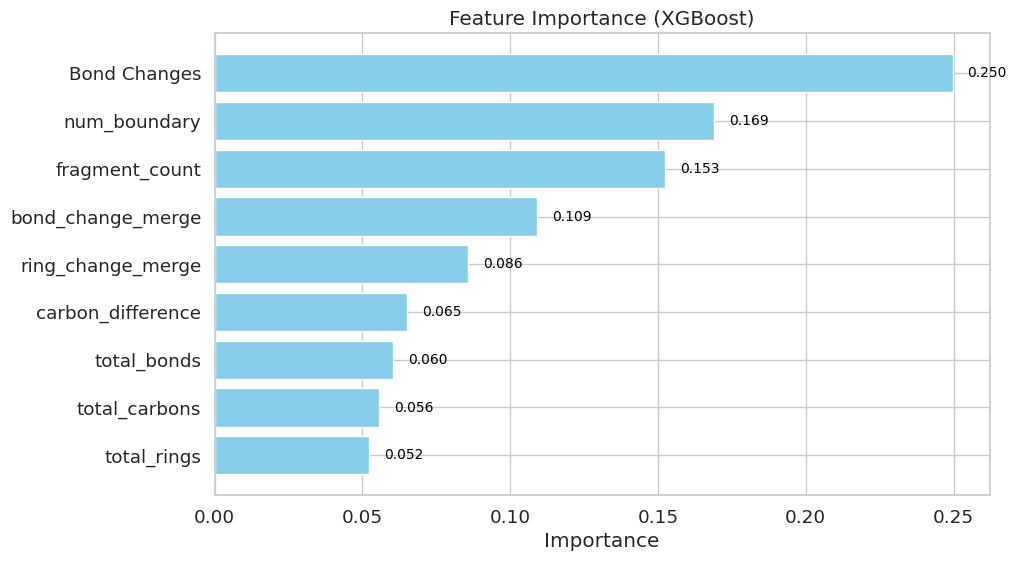

In [456]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

# Assuming you have a DataFrame df with X columns and 'Result' as the target variable
X = data_check.drop('Result', axis=1)
y = data_check['Result']

# Create an XGBoost classifier
#clf = xgb.XGBClassifier()
clf = xgb.XGBClassifier()
# Fit the model on your data
clf.fit(X, y)

# Get feature importances
feature_importances = clf.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importances with color and values
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')

# Add values on top of the bars
for bar, val in zip(bars, importance_df['Importance']):
    plt.text(val + 0.005, bar.get_y() + bar.get_height() / 2, f'{val:.3f}', va='center', fontsize=10, color='black')

plt.xlabel('Importance')
#plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()


/homes/biertank/tieu/miniconda3/envs/SynRBL/lib/python3.9/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


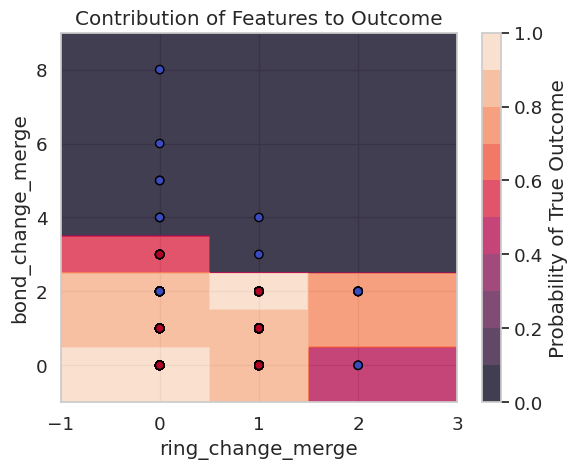

In [470]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
df = deepcopy(data_check.drop(['Bond Changes'], axis=1))
le = LabelEncoder()
df['Outcome'] = le.fit_transform(df['Result'])
# Correct setup for logistic regression
X = df[['ring_change_merge', 'bond_change_merge']]
y = df['Outcome']  # Correct target variable
#model = LogisticRegression()
#model = xgb.XGBClassifier(random_state=42)
model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)

# Create a mesh grid for the feature space
x_min, x_max = X['ring_change_merge'].min() - 1, X['ring_change_merge'].max() + 1
y_min, y_max = X['bond_change_merge'].min() - 1, X['bond_change_merge'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict probabilities over the mesh grid
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]  # Probability of class 1
Z = Z.reshape(xx.shape)

# Generate contour plot
plt.contourf(xx, yy, Z, alpha=0.8, levels=np.linspace(0, 1, 11))
plt.colorbar(label='Probability of True Outcome')
plt.xlabel('ring_change_merge')
plt.ylabel('bond_change_merge')
plt.title('Contribution of Features to Outcome')

# Plot also the training points, coloring them by the outcome
# If the 'Outcome' is not numeric, you should convert it to numeric for coloring
plt.scatter(X['ring_change_merge'], X['bond_change_merge'], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
plt.show()


## Train model

In [532]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
data_raw = process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=False).drop(['R-id', 'reactions', 'Index'], axis =1)
X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [533]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299 entries, 0 to 2298
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   carbon_difference    2299 non-null   int64  
 1   fragment_count       2299 non-null   int64  
 2   total_carbons        2299 non-null   int64  
 3   total_bonds          2299 non-null   int64  
 4   total_rings          2299 non-null   int64  
 5   Result               2298 non-null   object 
 6   Bond Changes         2298 non-null   float64
 7   mcs_carbon_balanced  2298 non-null   object 
 8   num_boundary         2298 non-null   float64
 9   ring_change_merge    2298 non-null   float64
 10  bond_change_merge    2298 non-null   float64
dtypes: float64(4), int64(5), object(2)
memory usage: 197.7+ KB


In [569]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

data_raw = process_and_combine_datasets(list_data, pipeline_path, data_path, remove_undetected=False).drop(['R-id', 'reactions', 'Index'], axis =1)
X, y = data_raw.drop('Result', axis=1), data_raw['Result']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [571]:
# Define your preprocessing pipeline
preprocessing_steps = [
    ('scaler', MinMaxScaler()),
    # Add other preprocessing steps as needed
]

preprocessing_pipeline = Pipeline(preprocessing_steps)

# Combine preprocessing and SMOTE into a single pipeline
resampling_pipeline = ImbPipeline([
    ('preprocessing', preprocessing_pipeline),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # Adjust sampling_strategy as needed
])

# Create a final pipeline with preprocessing, SMOTE, and XGBoost
final_pipeline = Pipeline([
    ('resampling', resampling_pipeline),
    ('xgboost', XGBClassifier(random_state=42)),
])

# Fit the final pipeline on the training data
final_pipeline.fit(X_train, y_train)

# Predict on the test data using the final pipeline
y_pred = final_pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'Pipeline(steps=[('preprocessing', Pipeline(steps=[('scaler', MinMaxScaler())])),
                ('smote', SMOTE(random_state=42))])' (type <class 'imblearn.pipeline.Pipeline'>) doesn't

In [572]:
from imblearn.pipeline import Pipeline
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from imblearn.pipeline import make_pipeline
model = make_pipeline(
    RandomUnderSampler(random_state=0),
    HistGradientBoostingClassifier(random_state=0)
)

In [525]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.66      0.75        74
           1       0.94      0.98      0.96       386

    accuracy                           0.93       460
   macro avg       0.91      0.82      0.86       460
weighted avg       0.93      0.93      0.93       460



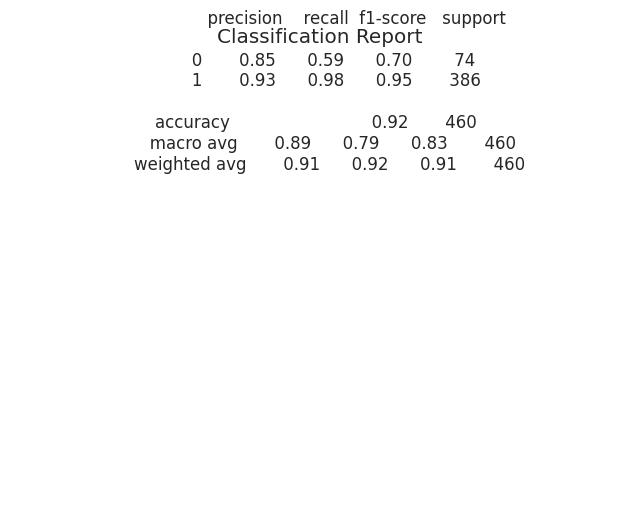

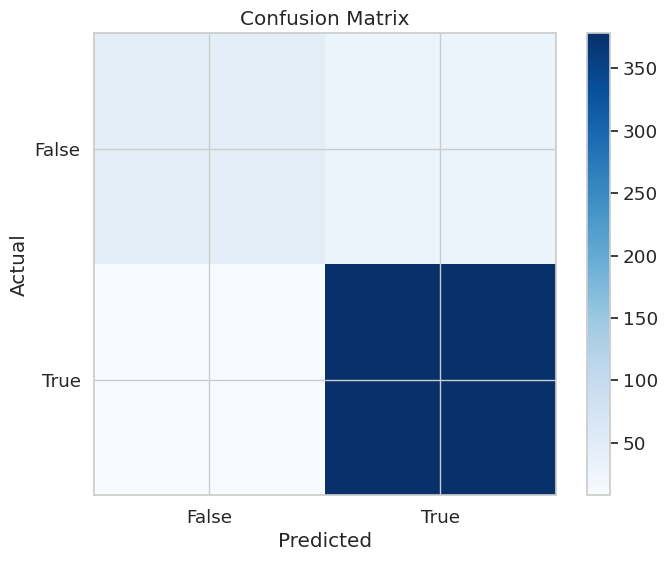

In [526]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Replace with your classifier

# Assuming you have X (features) and y (target) prepared

# Split the data into a training set and a test set (if not already done)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate and train your classification model (replace with your classifier)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Generate the classification report
class_report = classification_report(y_test, y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the classification report
plt.figure(figsize=(8, 6))
plt.text(0.2, 0.7, class_report, fontsize=12)
plt.title('Classification Report')
plt.axis('off')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['False', 'True'])
plt.yticks(tick_marks, ['False', 'True'])
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Show the plots
plt.show()


# Rule-based

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = [82.58, 82.64, 68.21, 91.86, 84.81]
accuracy = [99.73, 98.90, 99.38, 99.91, 99.58]

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 7))

# Using the "flare" colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)  # A specific color from the "flare" colormap for Success Rate
color_for_accuracy = cmap(0.7)  # A different specific color from the "flare" colormap for Accuracy

bars1 = ax.bar(index - bar_width/2, success_rate, bar_width, label='Success Rate', color=color_for_success_rate)
bars2 = ax.bar(index + bar_width/2, accuracy, bar_width, label='Accuracy', color=color_for_accuracy)

#plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 120)

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


In [ ]:
data3

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

def add_error_bars(values, sample_sizes):
    """Calculate and return the confidence intervals."""
    lower_bounds, upper_bounds = proportion_confint(values * sample_sizes, sample_sizes, method='wilson')
    errors = [values - lower_bounds, upper_bounds - values]  # lower and upper errors
    return errors

# Data
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportion
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportion
unbalance = [913, 219, 475, 1253, 283]
sample_sizes = np.array(unbalance)  # Assuming 'unbalance' is the sample size
sample_sizes_success = np.array(unbalance)
# Error calculations
success_rate_errors = add_error_bars(success_rate, sample_sizes)
accuracy_errors = add_error_bars(accuracy, sample_sizes)

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 8))
ax2 = ax.twinx()

# Using the "flare" colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)
color_for_accuracy = cmap(0.7)
color_for_unbalance = cmap(0.5)

# Plotting bars with error bars
bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=np.array(success_rate_errors)*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=np.array(accuracy_errors)*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})

# Line plot for number of samples
bars3 = ax2.plot(index, unbalance, label='Number of Samples', color=color_for_unbalance, marker='o')

plt.ylabel('Percentage (%)', fontsize=12)
ax2.set_ylabel('Number of Samples', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 120)
ax2.set_ylim(0, max(unbalance) * 1.2)

ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.proportion import proportion_confint

# Data
datasets = ["Golden dataset", "Jaworski", "$\mathcal{U}_{\mathrm{Random}}$", "$\mathcal{U}_{\mathrm{Diff}}$", "$\mathcal{U}_{\mathrm{Unbalance}}$"]
success_rate = np.array([82.58, 82.64, 68.21, 91.86, 84.81]) / 100  # Convert to proportions
accuracy = np.array([99.73, 98.90, 99.38, 99.91, 99.58]) / 100  # Convert to proportions
unbalance = np.array([913, 219, 475, 1253, 283])

# Successes and accuracies
successes = np.round(unbalance * success_rate).astype(int)
accuracies = np.round(successes * accuracy).astype(int)

# Confidence intervals
confint_success = proportion_confint(successes, unbalance, method='wilson')
confint_accuracy = proportion_confint(accuracies, successes, method='wilson')

# Error margins
error_success = np.abs(np.vstack(confint_success) - success_rate)
error_accuracy = np.abs(np.vstack(confint_accuracy) - accuracy)

bar_width = 0.35
index = np.arange(len(datasets))

fig, ax = plt.subplots(figsize=(14, 7))

# Colormap
cmap = plt.get_cmap('flare')
color_for_success_rate = cmap(0.3)
color_for_accuracy = cmap(0.7)

# Plotting
bars1 = ax.bar(index - bar_width/2, success_rate*100, bar_width, yerr=error_success*100, capsize=5, label='Success Rate', color=color_for_success_rate, error_kw={'ecolor':'black', 'elinewidth':2})
bars2 = ax.bar(index + bar_width/2, accuracy*100, bar_width, yerr=error_accuracy*100, capsize=5, label='Accuracy', color=color_for_accuracy, error_kw={'ecolor':'black', 'elinewidth':2})

# Labels and styling
plt.ylabel('Percentage (%)', fontsize=12)
plt.title('Success Rate and Accuracy of Validation Datasets', fontsize=14, fontweight='bold')
plt.xticks(index, datasets, rotation=45, ha='right', fontsize=10)
plt.ylim(0, 105)
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')

# Annotation function
def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

annotate_bars(bars1)
annotate_bars(bars2)

# Legend and layout
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.subplots_adjust(right=0.78)
plt.savefig('rule_based.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


# analysis MCS

In [ ]:
from SynRBL.SynMCSImputer.SubStructure.mcs_process import ensemble_mcs
from SynRBL.SynUtils.data_utils import load_database, save_database
from SynRBL.SynMCSImputer.SubStructure.extract_common_mcs import ExtractMCS
from SynRBL.SynMCSImputer.MissingGraph.find_graph_dict import find_graph_dict
from SynRBL.SynMCSImputer.MissingGraph.refinement_uncertainty import RefinementUncertainty

mcs1 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_1.json.gz')
mcs2 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_2.json.gz')
mcs3 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_3.json.gz')
mcs4 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_4.json.gz')
mcs5 = load_database('../../../Data/Validation_set/golden_dataset/MCS/Condition_5.json.gz')

In [ ]:
mcs_check_uncertainty('USPTO_unbalance_class')

In [ ]:
data_name = 'golden_dataset'
mcs_dir = f'../../../Data/Validation_set/{data_name}/MCS'
missing_results_largest  = find_graph_dict(msc_dict_path=f'{mcs_dir}/MCS_Largest.json.gz', 
                                            save_path= './test.json.gz')

In [ ]:
datasets = ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble']
golden = [256, 279, 211, 269, 398, 195]
jaworski = [26, 30, 22, 33, 46, 21]
random = [66, 80, 60, 75, 203, 60]
diff = [44, 50, 42, 45, 128, 40]
unbalance = [37, 37, 33, 35, 130, 33]


In [ ]:
# golden
# Uncertainty Data: 256
# STOP HERE Condition_1
# Uncertainty Data: 279
# STOP HERE Condition_2
# Uncertainty Data: 211
# STOP HERE Condition_3
# Uncertainty Data: 269
# STOP HERE Condition_4
# Uncertainty Data: 398
# STOP HERE Condition_5
# Uncertainty Data: 195
# STOP HERE MCS_Largest

# jaworski
# Uncertainty Data: 26
# STOP HERE Condition_1
# Uncertainty Data: 30
# STOP HERE Condition_2
# Uncertainty Data: 22
# STOP HERE Condition_3
# Uncertainty Data: 33
# STOP HERE Condition_4
# Uncertainty Data: 46
# STOP HERE Condition_5
# Uncertainty Data: 21
# STOP HERE MCS_Largest

# random class
#     Uncertainty Data: 66
# STOP HERE Condition_1
# Uncertainty Data: 80
# STOP HERE Condition_2
# Uncertainty Data: 60
# STOP HERE Condition_3
# Uncertainty Data: 75
# STOP HERE Condition_4
# Uncertainty Data: 203
# STOP HERE Condition_5
# Uncertainty Data: 60
# STOP HERE MCS_Largest

# unbalance
# Uncertainty Data: 37
# STOP HERE Condition_1
# Uncertainty Data: 37
# STOP HERE Condition_2
# Uncertainty Data: 33
# STOP HERE Condition_3
# Uncertainty Data: 35
# STOP HERE Condition_4
# Uncertainty Data: 130
# STOP HERE Condition_5
# Uncertainty Data: 33
# STOP HERE MCS_Largest




# diff
# Uncertainty Data: 44
# STOP HERE Condition_1
# Uncertainty Data: 50
# STOP HERE Condition_2
# Uncertainty Data: 42
# STOP HERE Condition_3
# Uncertainty Data: 45
# STOP HERE Condition_4
# Uncertainty Data: 128
# STOP HERE Condition_5
# Uncertainty Data: 40
# STOP HERE MCS_Largest

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Plot
plt.figure(figsize=(15, 8))
bar_plot = sns.barplot(x='Dataset', y='Value', hue='Configuration', data=df, palette=palette)

# Customizing the plot
plt.title('Effect of Ensemble Method in Reducing Uncertainty', fontsize=14)
plt.ylabel('Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate each bar with the value
for p in bar_plot.patches:
    print()
    text = format(p.get_height(), '.0f')
    bar_plot.annotate(text, (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=10)

plt.tight_layout()
plt.savefig('./benchmark_mcs.pdf', dpi=300)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars
plt.figure(figsize=(10, 6))
plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(10, 6))
bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["Configuration 1", "Configuration 2", "Configuration 3", "Configuration 4", "Configuration 5", 'Ensemble'] * 5,
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6 + ["$\mathcal{U}_{\mathrm{Random}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Diff}}$"] * 6 + ["$\mathcal{U}_{\mathrm{Unbalance}}$"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('flare')  # Adjusted color palette
num_configs = len(df['Configuration'].unique())
palette = [cmap(i/num_configs) for i in range(num_configs)]
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette[-1] = ensemble_color  # Assign the distinct color to Ensemble

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(12, 6))

# Adding background color
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Configuration in MCS', fontsize=16, weight='semibold')
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # White grid lines for contrast

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data
data = {
    "Configuration": ["RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                       "RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                       "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                       "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                       "MCES\nMCES",
                       "Ensemble: Largest"],  # Added "Ensemble: Largest" configuration
    "Dataset": ["Golden dataset"] * 6 + ["Jaworski"] * 6,
    "Value": [256, 279, 211, 269, 398, 195, 26, 30, 22, 33, 46, 21, 66, 80, 60, 75, 203, 60, 44, 50, 42, 45, 128, 40, 37, 37, 33, 35, 130, 33]
}

df = pd.DataFrame(data)

# Custom color palette
cmap = plt.get_cmap('viridis')  # Adjusted color palette
num_configs = len(df['Configuration'].unique())
palette = [cmap(i / (num_configs - 1)) for i in range(num_configs - 1)]  # Exclude the last color for "Ensemble: Largest"
ensemble_color = "#e377c2"  # Distinct color for Ensemble
palette.append(ensemble_color)  # Add the distinct color to "Ensemble: Largest"

# Calculate the sum and standard deviation of each configuration
sum_data = df.groupby('Configuration')['Value'].sum()
std_data = df.groupby('Configuration')['Value'].std()

# Create a new figure with error bars and values on top of bars
plt.figure(figsize=(12, 6))

# Adding background color
ax = plt.gca()
ax.set_facecolor('#f0f0f0')  # Light gray background

bars = plt.bar(sum_data.index, sum_data, yerr=std_data, capsize=5, color=palette)

# Customizing the plot
plt.title('Comparison of the Sum of Each Configuration with Error Bars', fontsize=14)
plt.ylabel('Total Uncertainty Data', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7, color='white')  # White grid lines for contrast

# Annotate each bar with the value on top
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.0f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

# Create a custom legend
legend_labels = ["RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                 "RingMatchesRingOnly\nCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                 "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIgnoreBondOrder",
                 "NotRingMatchesRingOnly\nNotCompleteRingsOnly\nMCIS\nMCIS\nIncludeBondOrder",
                 "MCES\nMCES",
                 "Ensemble: Largest"]  # Added legend label for "Ensemble: Largest"

legend_colors = [palette[i] for i in range(num_configs)]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=legend_colors[i], ec="k", lw=1) for i in range(num_configs)]

plt.legend(legend_handles, legend_labels, title='Configuration', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()
